In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.io import RawArray
from mne import create_info, EpochsArray
from mne_icalabel import label_components
from mne.decoding import Scaler
import os

In [2]:
folder_path = "dataset/STEW Dataset/"
files = os.listdir(folder_path)

In [3]:
ratings = files[0]
sub_files = files[1:]

In [4]:
sub_files

['sub01_hi.txt',
 'sub01_lo.txt',
 'sub02_hi.txt',
 'sub02_lo.txt',
 'sub03_hi.txt',
 'sub03_lo.txt',
 'sub04_hi.txt',
 'sub04_lo.txt',
 'sub05_hi.txt',
 'sub05_lo.txt',
 'sub06_hi.txt',
 'sub06_lo.txt',
 'sub07_hi.txt',
 'sub07_lo.txt',
 'sub08_hi.txt',
 'sub08_lo.txt',
 'sub09_hi.txt',
 'sub09_lo.txt',
 'sub10_hi.txt',
 'sub10_lo.txt',
 'sub11_hi.txt',
 'sub11_lo.txt',
 'sub12_hi.txt',
 'sub12_lo.txt',
 'sub13_hi.txt',
 'sub13_lo.txt',
 'sub14_hi.txt',
 'sub14_lo.txt',
 'sub15_hi.txt',
 'sub15_lo.txt',
 'sub16_hi.txt',
 'sub16_lo.txt',
 'sub17_hi.txt',
 'sub17_lo.txt',
 'sub18_hi.txt',
 'sub18_lo.txt',
 'sub19_hi.txt',
 'sub19_lo.txt',
 'sub20_hi.txt',
 'sub20_lo.txt',
 'sub21_hi.txt',
 'sub21_lo.txt',
 'sub22_hi.txt',
 'sub22_lo.txt',
 'sub23_hi.txt',
 'sub23_lo.txt',
 'sub24_hi.txt',
 'sub24_lo.txt',
 'sub25_hi.txt',
 'sub25_lo.txt',
 'sub26_hi.txt',
 'sub26_lo.txt',
 'sub27_hi.txt',
 'sub27_lo.txt',
 'sub28_hi.txt',
 'sub28_lo.txt',
 'sub29_hi.txt',
 'sub29_lo.txt',
 'sub30_hi.txt

In [5]:
y = np.array([1, 0]*45)

In [6]:
from mne.io import RawArray
from mne import create_info, EpochsArray
from mne_icalabel import label_components
from scipy import signal

In [7]:
DEFAULT_SLEW_LIMIT = 30

def iqm_filter(eeg_data):
    # Rereferencing by removing the interquartile mean of the data.
    n_chans = eeg_data.shape[1]
    quart = n_chans // 4
    iq_idx = slice(quart, n_chans - quart)
    sorted = np.sort(eeg_data, axis=1)
    medians = np.mean(sorted[:, iq_idx], axis=1).reshape(-1, 1)
    return np.subtract(eeg_data, medians)


def get_hpf_zi(b, a, eeg_data):
    # Get initial zi parameter for filter
    zi = []
    for ch in range(eeg_data.shape[1]):
        y = []
        N = min(256, eeg_data.shape[0])
        m = np.mean(eeg_data[0:N, ch])
        for i in range(len(b) - 1, -1, -1):
            y.append(eeg_data[i, ch] - m)
        z = signal.lfiltic(b, a, y, x=eeg_data[len(a) - 2::-1, ch])
        zi.append(z)
    return np.array(zi).T.reshape(len(a) - 1, -1)


def ab_filter(eeg_data):
    a = [1., -1.96529337, 0.96588546]
    b = [0.98279471, -1.96558942, 0.98279471]
    zi = get_hpf_zi(b, a, eeg_data)
    filtered_data, zi = signal.lfilter(b, a, eeg_data, axis=0, zi=zi)
    return filtered_data


def limit_slew_rate(eeg_data, slew_limit=DEFAULT_SLEW_LIMIT):
    # Remove large steps in the data to avoid filter settling time
    n_chans = eeg_data.shape[1]
    first_row = eeg_data[0, :].reshape(1, -1).copy()
    eeg_data = np.vstack((first_row, eeg_data))
    deltas = eeg_data[1:, :] - eeg_data[0:-1, :]
    max_deltas = np.ones(deltas.shape) * slew_limit
    deltas = np.minimum(deltas, max_deltas)
    min_deltas = max_deltas * -1
    deltas = np.maximum(deltas, min_deltas)
    limited = np.cumsum(deltas, axis=0)
    return limited


def preproc(eeg_data):
    eeg_data = limit_slew_rate(eeg_data)
    eeg_data = ab_filter(eeg_data)
    eeg_data = iqm_filter(eeg_data)
    return eeg_data

In [8]:
channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
info = create_info(ch_names=channels, sfreq=128, ch_types="eeg")

data = np.vstack([[np.loadtxt(folder_path + sub_file, dtype=np.float64) for sub_file in sub_files]])
data = np.delete(data, [8, 9, 46, 47, 82, 83], 0)
data = np.vstack([[preproc(data[i]) for i in range(len(data))]])
data = data.transpose((0, 2, 1))
raws = [RawArray(data[i].copy(), info=info, verbose=0) for i in range(len(data))]

montage = mne.channels.make_standard_montage('standard_1020')
raws = [raw.set_montage(montage) for raw in raws]
raws = [raw.set_eeg_reference("average", verbose=0) for raw in raws]

In [9]:
X = np.vstack([[raws[i].copy().get_data() for i in range(len(raws))]])

In [10]:
for raw in raws:
    raw.filter(l_freq=1, h_freq=63.9, verbose=0)
    raw.set_eeg_reference("average", verbose=0)

Using matplotlib as 2D backend.


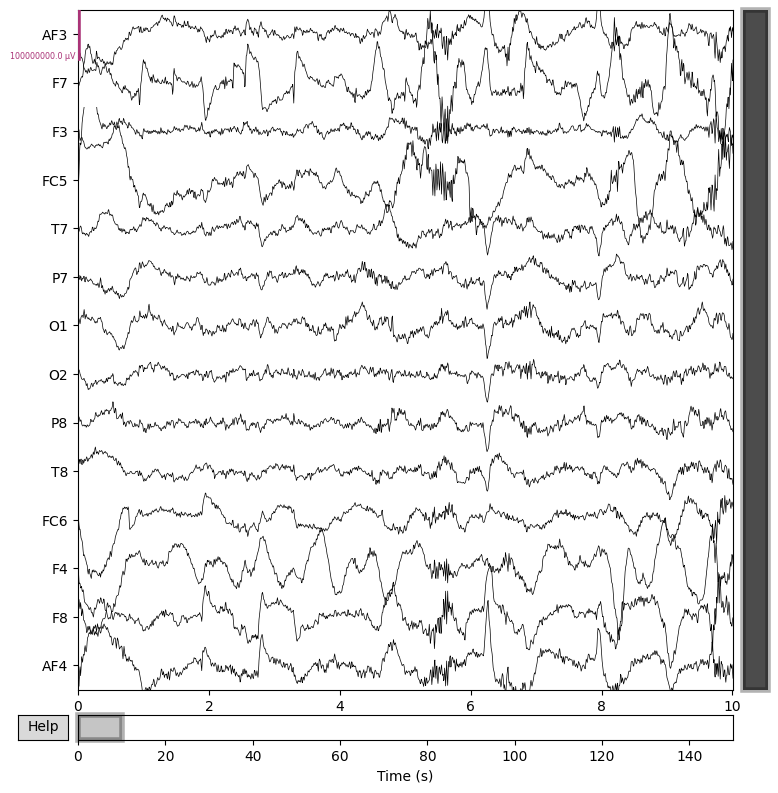

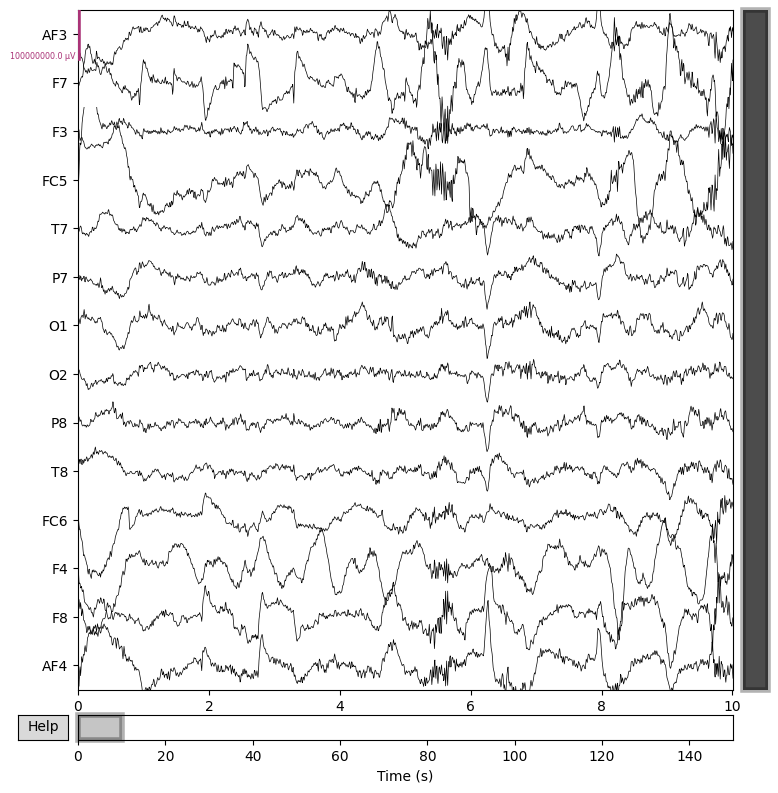

In [11]:
raws[0].plot(scalings = dict(eeg=50))

In [12]:
mus_inds_list = []
ica_list = []
ic_labels_list = []
components_flag_dict = {"eye blink": 0, "heart beat": 0, "muscle artifact": 0, "line noise": 0, 
                        "channel noise": 0, "other": 0}

for raw in raws:
    ica = mne.preprocessing.ICA(n_components=13, random_state=97, method="infomax", fit_params=dict(extended=True))
    ica.fit(raw, verbose=0)
    ica_list.append(ica)
    mus_inds, mus_scores = ica.find_bads_muscle(raw, verbose=0)
    mus_inds_list.append(mus_inds)
    ic_labels = label_components(raw, ica, method="iclabel")
    ic_labels_list.append(ic_labels["labels"])
    for key in components_flag_dict.keys():
        if key in ic_labels["labels"] and key != "muscle artifact":
            components_flag_dict[key] += 1
    if len(mus_inds) > 0:
        components_flag_dict["muscle artifact"] += 1

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\sh204\AppData\Local\Temp\ipykernel_2464\3998698722.py:13: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")


In [13]:
components_flag_dict

{'eye blink': 79,
 'heart beat': 0,
 'muscle artifact': 84,
 'line noise': 1,
 'channel noise': 34,
 'other': 90}

In [14]:
all_data = []
for i in range(len(ic_labels_list)):
    labels = ic_labels_list[i]
    
    # eye artifact removal
    eye_inds = [j for j, label in enumerate(labels) if labels == "eye blink"]
    ica_list[i].exclude = eye_inds
    raw_eye_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    x_filter_eye_removed = raw_eye_removed.get_data()

    # # heart artifact removal
    # heart_inds = [j for j, label in enumerate(labels) if labels == "heart beat"]
    # ica_list[i].exclude = heart_inds
    # raw_heart_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    # x_filter_heart_removed = raw_heart_removed.get_data()
    
    # muscle artifact removal
    mus_inds = mus_inds_list[i]
    ica_list[i].exclude = mus_inds
    raw_muscle_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    x_filter_muscle_removed = raw_muscle_removed.get_data()

    # # line noise removal
    # line_inds = [j for j, label in enumerate(labels) if labels == "line noise"]
    # ica_list[i].exclude = line_inds
    # raw_line_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    # x_filter_line_removed = raw_line_removed.get_data()

    # channel noise removal
    channel_inds = [j for j, label in enumerate(labels) if labels == "channel noise"]
    ica_list[i].exclude = channel_inds
    raw_channel_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    x_filter_channel_removed = raw_channel_removed.get_data()

    # all removal
    ica_list[i].exclude = list(set(eye_inds + mus_inds + channel_inds))
    raw_all_removed = ica_list[i].apply(raws[i].copy(), verbose=0)
    x_filter_all_removed = raw_all_removed.get_data()


    x = X[i].copy()
    x_filter = raws[i].copy().get_data()
    all_data.append(np.vstack([[x, x_filter, x_filter_eye_removed, x_filter_muscle_removed, x_filter_channel_removed, x_filter_all_removed]]))

In [15]:
all_data = np.array(all_data)

In [16]:
all_data.shape

(90, 6, 14, 19200)

In [17]:
np.savez('dataset/STEW_filter_artifact_removal.npz', 
         x_all=all_data, y_all=y
        )

x_all:  
(90, 6, 14, 19200)  
(被験者数*2(hi, lo) アウトプットの種類, チャンネル数, 時間ステップ (2.5min, s_freq=128Hz))  
アウトプットの種類について：  
1. x
2. x_filter
3. x_filter_eye
4. x_filter_muscle
5. x_filter_channel
6. x_filter_all

y_all:  
(90, )  
(被験者数*2(hi, lo))

In [34]:
data = np.load('dataset/STEW_filter_artifact_removal.npz')